<a href="https://colab.research.google.com/github/ayulockin/DataAugmentationTF/blob/master/CIFAR_10_with_CutMix_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

In [1]:
!nvidia-smi

Tue Jun 30 07:59:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## This is so that I can save my models.
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
!git clone https://github.com/ayulockin/DataAugmentationTF

Cloning into 'DataAugmentationTF'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 51 (delta 22), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [5]:
%cd DataAugmentationTF/

/content/DataAugmentationTF


In [6]:
!ls

augment_and_mix.py
augmentations.py
CIFAR_10_Baseline_Model.ipynb
Cifar_10_Evaluation_Robustness_to_Cifar_10C.ipynb
CIFAR_10_with_AugMix_Augmentation.ipynb
CIFAR_10_with_CutMix_Augmentation.ipynb
CIFAR_10_with_Cutout_Augmentation.ipynb
CIFAR_10_with_Mixup_Augmentation.ipynb
images
models
README.md


In [7]:
%%capture
!pip install wandb

In [8]:
SEED = 666

import tensorflow as tf
tf.random.set_seed(SEED)

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import resnet50

import tensorflow_probability as tfp
tfd = tfp.distributions

In [9]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
np.random.seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

In [10]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


# Download and Prepare Dataset

#### CIFAR-10

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = pd.get_dummies(y_train.flatten()).values.astype(np.float32)
y_test = pd.get_dummies(y_test.flatten()).values.astype(np.float32)

170500096/170498071 [==============================] - 2s 0us/step


In [12]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [13]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


# Visualize

In [14]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[np.argmax(label_batch[n])])
      plt.axis('off')

#### Train Set

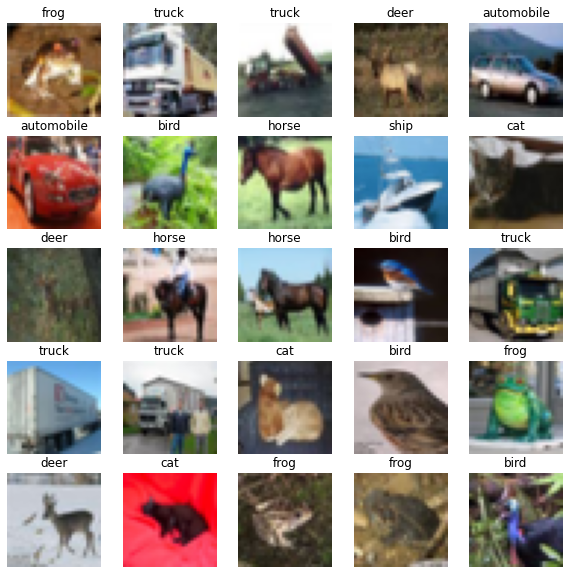

In [15]:
image_batch, label_batch = x_train[:32], y_train[:32]
show_batch(image_batch, label_batch)

#### Test Set

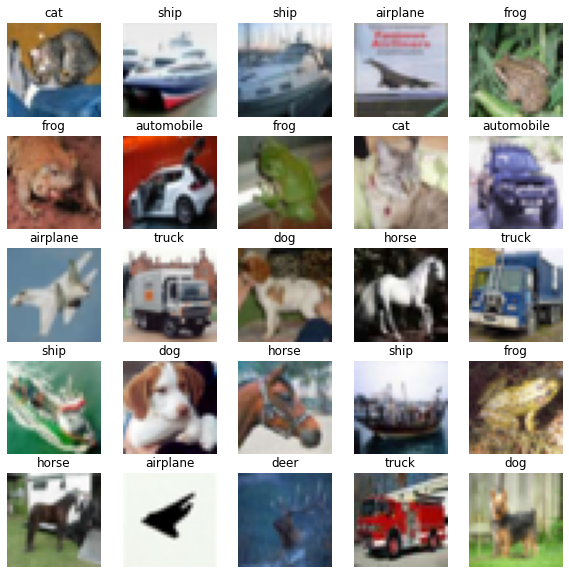

In [16]:
image_batch, label_batch = x_test[:32], y_test[:32]
show_batch(image_batch, label_batch)

# Model

In [17]:
from models.resnet import resnet_v1

In [18]:
def Model():
  return resnet_v1((32,32,3), 20) ## Returns a ResNet20 model.

# Callbacks

In [19]:
earlystoper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    restore_best_weights=True ## This will ensure the best instance of the model over the validation set.
)

# Train with CutMix Augmentation

#### CutMix Dataloader

In [20]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SHAPE = 32

In [21]:
def preprocess_image(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = image/255.
  return image, label

In [22]:
@tf.function
def get_bbox(l):
  cut_rat = tf.math.sqrt(1.-l)

  cut_w = IMG_SHAPE*cut_rat #rw
  cut_w = tf.cast(cut_w, tf.int32)
  
  cut_h = IMG_SHAPE*cut_rat #rh
  cut_h = tf.cast(cut_h, tf.int32)
  
  cx = tf.random.uniform((1,), minval=0, maxval=IMG_SHAPE, dtype=tf.int32) #rx
  cy = tf.random.uniform((1,), minval=0, maxval=IMG_SHAPE, dtype=tf.int32) #ry
  
  bbx1 = tf.clip_by_value(cx[0] - cut_w // 2, 0, IMG_SHAPE)
  bby1 = tf.clip_by_value(cy[0] - cut_h // 2, 0, IMG_SHAPE)
  bbx2 = tf.clip_by_value(cx[0] + cut_w // 2, 0, IMG_SHAPE)
  bby2 = tf.clip_by_value(cy[0] + cut_h // 2, 0, IMG_SHAPE)
  
  target_h = bby2-bby1
  if target_h ==0:
    target_h+=1

  target_w = bbx2-bbx1
  if target_w ==0:
    target_w+=1

  return bbx1, bby1, target_h, target_w

@tf.function
def cutmix(a, b):
  
  (image1, label1), (image2, label2) = a, b

  alpha = [1.]
  beta = [1.]
  
  ## Get sample from beta distribution
  dist = tfd.Beta(alpha, beta)
  ## Lambda
  l = dist.sample(1)[0][0]

  ## Get bbox ofsets and heights and widths
  bbx1, bby1, target_h, target_w = get_bbox(l)

  ## Get patch from image2
  crop2 = tf.image.crop_to_bounding_box(image2, bby1, bbx1, target_h, target_w)
  ## Pad the patch with same offset
  image2 = tf.image.pad_to_bounding_box(crop2, bby1, bbx1, IMG_SHAPE, IMG_SHAPE)
  ## Get patch from image1
  crop1 = tf.image.crop_to_bounding_box(image1, bby1, bbx1, target_h, target_w)
  ## Pad the patch with same offset
  img1 = tf.image.pad_to_bounding_box(crop1, bby1, bbx1, IMG_SHAPE, IMG_SHAPE)

  ## Subtract the patch from image1 so that patch from image2 can be put on instead
  image1 = image1-img1
  ## Add modified image1 and image2 to get cutmix image
  image = image1+image2

  ## Adjust lambda according to pixel ration
  l = 1 - (target_w * target_h) / (IMG_SHAPE * IMG_SHAPE)
  l = tf.cast(l, tf.float32)

  ## Combine labels
  label = l*label1+(1-l)*label2

  return image, label

In [23]:
trainloader1 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)
trainloader2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)

trainloader = tf.data.Dataset.zip((trainloader1, trainloader2))
trainloader = (
    trainloader
    .shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

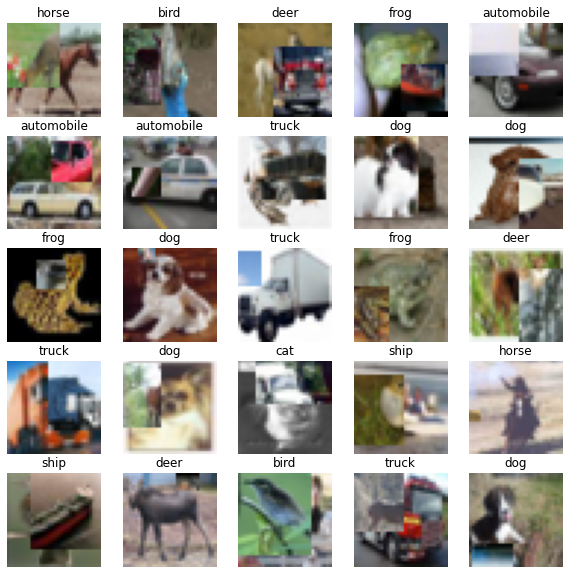

In [24]:
image_batch, label_batch = next(iter(trainloader))
image_batch.shape, label_batch.shape

show_batch(image_batch, label_batch)

#### Initialize Model

In [25]:
keras.backend.clear_session()
model = Model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Compile

In [26]:
model.compile('adam', 'categorical_crossentropy', metrics=['acc'])

#### Wandb Init

In [27]:
wandb.init(entity='authors', project='tfaugmentation')

W&B Run: https://app.wandb.ai/authors/tfaugmentation/runs/o3p7a3ls

#### Train

In [28]:
EPOCHS = 100

_ = model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     earlystoper])

Epoch 1/100
1563/1563 [==============================] - 72s 46ms/step - loss: 2.0010 - acc: 0.3884 - val_loss: 1.6592 - val_acc: 0.4639
Epoch 2/100
1563/1563 [==============================] - 71s 46ms/step - loss: 1.7674 - acc: 0.5044 - val_loss: 1.2956 - val_acc: 0.5965
Epoch 3/100
1563/1563 [==============================] - 71s 45ms/step - loss: 1.6710 - acc: 0.5510 - val_loss: 1.1914 - val_acc: 0.6315
Epoch 4/100
1563/1563 [==============================] - 71s 46ms/step - loss: 1.6100 - acc: 0.5817 - val_loss: 1.0379 - val_acc: 0.6988
Epoch 5/100
1563/1563 [==============================] - 71s 45ms/step - loss: 1.5732 - acc: 0.6024 - val_loss: 0.9340 - val_acc: 0.7508
Epoch 6/100
1563/1563 [==============================] - 71s 45ms/step - loss: 1.5429 - acc: 0.6173 - val_loss: 0.8894 - val_acc: 0.7651
Epoch 7/100
1563/1563 [==============================] - 70s 45ms/step - loss: 1.5206 - acc: 0.6267 - val_loss: 1.0595 - val_acc: 0.6764
Epoch 8/100
1563/1563 [==================

#### Save your hardwork

In [32]:
%cd ../../

/


In [33]:
model.save('gdrive/My Drive/DataAugmentation/cutmix.h5')

## Evaluate

#### Evaluate on CIFAR-10

In [34]:
loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()])
print('Test Error Rate: ', round((1-accuracy)*100,2))

313/313 [==============================] - 4s 11ms/step - loss: 0.7533 - acc: 0.8161
Test Error Rate:  18.39


# Ablation Study

In [25]:
def prepare_trainloader(alpha):
  @tf.function
  def get_bbox(l):
    cut_rat = tf.math.sqrt(1.-l)

    cut_w = IMG_SHAPE*cut_rat #rw
    cut_w = tf.cast(cut_w, tf.int32)
    
    cut_h = IMG_SHAPE*cut_rat #rh
    cut_h = tf.cast(cut_h, tf.int32)
    
    cx = tf.random.uniform((1,), minval=0, maxval=IMG_SHAPE, dtype=tf.int32) #rx
    cy = tf.random.uniform((1,), minval=0, maxval=IMG_SHAPE, dtype=tf.int32) #ry
    
    bbx1 = tf.clip_by_value(cx[0] - cut_w // 2, 0, IMG_SHAPE)
    bby1 = tf.clip_by_value(cy[0] - cut_h // 2, 0, IMG_SHAPE)
    bbx2 = tf.clip_by_value(cx[0] + cut_w // 2, 0, IMG_SHAPE)
    bby2 = tf.clip_by_value(cy[0] + cut_h // 2, 0, IMG_SHAPE)
    
    target_h = bby2-bby1
    if target_h ==0:
      target_h+=1

    target_w = bbx2-bbx1
    if target_w ==0:
      target_w+=1

    return bbx1, bby1, target_h, target_w

  @tf.function
  def cutmix(a, b):
    
    (image1, label1), (image2, label2) = a, b
    
    ## Get sample from beta distribution
    dist = tfd.Beta(alpha, alpha)
    ## Lambda
    l = dist.sample(1)[0]

    ## Get bbox ofsets and heights and widths
    bbx1, bby1, target_h, target_w = get_bbox(l)

    ## Get patch from image2
    crop2 = tf.image.crop_to_bounding_box(image2, bby1, bbx1, target_h, target_w)
    ## Pad the patch with same offset
    image2 = tf.image.pad_to_bounding_box(crop2, bby1, bbx1, IMG_SHAPE, IMG_SHAPE)
    ## Get patch from image1
    crop1 = tf.image.crop_to_bounding_box(image1, bby1, bbx1, target_h, target_w)
    ## Pad the patch with same offset
    img1 = tf.image.pad_to_bounding_box(crop1, bby1, bbx1, IMG_SHAPE, IMG_SHAPE)

    ## Subtract the patch from image1 so that patch from image2 can be put on instead
    image1 = image1-img1
    ## Add modified image1 and image2 to get cutmix image
    image = image1+image2

    ## Adjust lambda according to pixel ration
    l = 1 - (target_w * target_h) / (IMG_SHAPE * IMG_SHAPE)
    l = tf.cast(l, tf.float32)

    ## Combine labels
    label = l*label1+(1-l)*label2

    return image, label
  
  trainloader1 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)
  trainloader2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)

  trainloader = tf.data.Dataset.zip((trainloader1, trainloader2))
  trainloader = (
      trainloader
      .shuffle(1024)
      .map(cutmix, num_parallel_calls=AUTO)
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
  )

  testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
  testloader = (
      testloader
      .map(preprocess_image, num_parallel_calls=AUTO)
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
  )

  return trainloader, testloader
  

In [26]:
ALPHAS = [0.1, 0.25, 0.5, 1.0, 2.0, 4.0]

In [27]:
keras.backend.clear_session()
model = Model()

model.save('initial_wt.h5')

In [28]:
count = 0
for alpha in ALPHAS:
  print('[INFO] Using alpha: ', alpha)
  ## Get cutout data loader with cutsize
  trainloader, testloader = prepare_trainloader(alpha)
  ## Initalize model
  keras.backend.clear_session()
  model = Model()
  model.load_weights('initial_wt.h5')
  ## Compile model
  model.compile('adam', 'categorical_crossentropy', metrics=['acc'])
  ## Wandb init
  wandb.init(entity='authors', project='tfaugmentation')
  _ = model.fit(trainloader,
          epochs=100,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     earlystoper])
  ## save model
  model.save('model_cutmix_{}.h5'.format(count))
  count+=1

[INFO] Using alpha:  0.1


Epoch 1/100
1563/1563 [==============================] - 79s 51ms/step - loss: 1.8755 - acc: 0.4200 - val_loss: 1.5018 - val_acc: 0.5153
Epoch 2/100
1563/1563 [==============================] - 77s 49ms/step - loss: 1.6017 - acc: 0.5487 - val_loss: 1.1813 - val_acc: 0.6358
Epoch 3/100
1563/1563 [==============================] - 77s 49ms/step - loss: 1.4917 - acc: 0.6010 - val_loss: 1.2482 - val_acc: 0.6291
Epoch 4/100
1563/1563 [==============================] - 78s 50ms/step - loss: 1.4230 - acc: 0.6317 - val_loss: 0.9818 - val_acc: 0.7192
Epoch 5/100
1563/1563 [==============================] - 76s 49ms/step - loss: 1.3776 - acc: 0.6542 - val_loss: 0.9999 - val_acc: 0.7174
Epoch 6/100
1563/1563 [==============================] - 75s 48ms/step - loss: 1.3440 - acc: 0.6674 - val_loss: 1.0208 - val_acc: 0.7117
Epoch 7/100
1563/1563 [==============================] - 78s 50ms/step - loss: 1.3188 - acc: 0.6802 - val_loss: 0.8778 - val_acc: 0.7538
Epoch 8/100
1563/1563 [==================

Epoch 1/100
1563/1563 [==============================] - 80s 51ms/step - loss: 1.9203 - acc: 0.4109 - val_loss: 1.4393 - val_acc: 0.5425
Epoch 2/100
1563/1563 [==============================] - 80s 51ms/step - loss: 1.6629 - acc: 0.5300 - val_loss: 1.1225 - val_acc: 0.6545
Epoch 3/100
1563/1563 [==============================] - 77s 49ms/step - loss: 1.5573 - acc: 0.5841 - val_loss: 1.0466 - val_acc: 0.6911
Epoch 4/100
1563/1563 [==============================] - 78s 50ms/step - loss: 1.4882 - acc: 0.6149 - val_loss: 1.0121 - val_acc: 0.7051
Epoch 5/100
1563/1563 [==============================] - 78s 50ms/step - loss: 1.4487 - acc: 0.6343 - val_loss: 1.0263 - val_acc: 0.7054
Epoch 6/100
1563/1563 [==============================] - 77s 49ms/step - loss: 1.4138 - acc: 0.6495 - val_loss: 0.9916 - val_acc: 0.7106
Epoch 7/100
1563/1563 [==============================] - 76s 49ms/step - loss: 1.3909 - acc: 0.6627 - val_loss: 0.9111 - val_acc: 0.7437
Epoch 8/100
1563/1563 [==================

In [29]:
ablation_dict = {}

for file in os.listdir('/content/DataAugmentationTF'):
  if file.endswith('.h5') and 'initial' not in file:
    model.load_weights('/content/DataAugmentationTF/'+file)
    loss, acc = model.evaluate(testloader, verbose=0)
    print(file, (1-acc)*100)
    ablation_dict[int(file.split('.')[0].split('_')[-1])] = round((acc)*100, 2)

model_cutmix_2.h5 16.850000619888306
model_cutmix_0.h5 16.089999675750732
model_cutmix_4.h5 16.780000925064087
model_cutmix_3.h5 20.31000256538391
model_cutmix_1.h5 17.22000241279602
model_cutmix_5.h5 17.3799991607666


In [30]:
ablation_dict

{0: 83.91, 1: 82.78, 2: 83.15, 3: 79.69, 4: 83.22, 5: 82.62}

In [32]:
alpha, test_acc = zip(*sorted(zip(list(ablation_dict.keys()), list(ablation_dict.values()))))

In [49]:
wandb.init(entity='authors', project='tfaugmentation')

for k, v in zip(alpha, test_acc):
  wandb.log({'alpha': k, 'test accuracy %': v})

In [50]:
plt.figure(figsize=(8,8))
plt.plot(cutsize, test_acc)
plt.title('Cut size vs test accuracy')
plt.xlabel('Cut Size')
plt.ylabel('Test Accuracy in %')
plt.grid(True)
# plt.show()

wandb.log({'alpha vs test accuracy': plt})
plt.close()

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

